In [1]:
##########################################################################
##
## Train the Model on Oxford-IIIT Pet Dataset
##
## Author:  Peizhi Yan
##   Date:  Apr. 7, 2021
##
##########################################################################

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers

import model.unet_xception as unet_xception
import model.icassp_multiscale as icassp_multiscale

import pet_dataset_handler as pet
from pet_dataset_handler import PetDataGenerator

from cosine_annealing import CosineAnnealingScheduler

import loss


W0408 18:49:08.879271 22440 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def plot_loss(history, save_path):
    # summarize history for loss
    plt.plot(history.history['loss'], color='indigo')
    #plt.plot(history.history['val_loss'], color='deepskyblue')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper right')
    plt.tight_layout()
    plt.savefig(fname=save_path, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
    plt.show()
    
def save_history(history, save_path):
    js = json.dumps(str(history.history))
    f = open(save_path,"w")
    f.write(js)
    f.close()

In [3]:

if not os.path.exists('./saved_models/'+EXPERIMENT_NAME):
    os.makedirs('./saved_models/'+EXPERIMENT_NAME)

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
tf.reset_default_graph()

""" Create the Xception network-based U-Net-like model """
#model = icassp_multiscale.get_model(img_size=(224,224), num_classes=1, M=4)
model = unet_xception.get_model(img_size=(224,224), num_classes=1)

""" Create training and validation data generators """
train_gen = PetDataGenerator(data_path='./data/224x224_train_pseudo/', batch_size=8, augmentation=True, shuffle=True, pseudo_label=True)

""" Optimizer """
opt = keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

""" Cosine annealing learning rate scheduler """
cos_annealing = CosineAnnealingScheduler(T_max=10, eta_max=1e-3, eta_min=1e-5)

""" Compile model """
model.compile(optimizer=opt, loss="mean_squared_error")

""" Train model """
callbacks = [cos_annealing]
##callbacks = []
history = model.fit(train_gen, epochs=20, verbose=1, callbacks=callbacks)

#""" Save model """
#model.save_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

""" Save history """
#save_history(history, save_path='./logs/'+EXPERIMENT_NAME+'.json')

""" Plot history """  
#plot_loss(history, save_path='./plots/'+EXPERIMENT_NAME+'.pdf')

NameError: name 'EXPERIMENT_NAME' is not defined

In [4]:
EXPERIMENT_NAME = 'pseudo_label__aug-True_iter-0' # initial training iteration

#""" Save model """
#model.save_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

#""" Load model """
model = unet_xception.get_model(img_size=(224,224), num_classes=1)
model.load_weights('./saved_models/'+EXPERIMENT_NAME+'.h5')

W0408 18:49:12.235672 22440 deprecation.py:506] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
# Load validation images
list_ids = []
for fname in os.listdir('./data/224x224/val'):
    if fname.startswith('_') == False and fname.endswith('.jpg'):
        list_ids.append(fname[:-4])        
val_x, val_y = pet.load_data(data_path='./data/224x224/val', list_ids=list_ids, width=224, height=224)
val_y = None; del val_y # remove val_y to save memory


W0408 18:49:25.558513 22440 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0408 18:49:25.639835 22440 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0408 18:49:25.725253 22440 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0408 18:49:25.758254 22440 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0408 18:49:25.787287 22440 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0408 18:49:25.816290 22440 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0408 18:49:25.846287 22440 image.py:709] Clipping input data to the valid range for ims

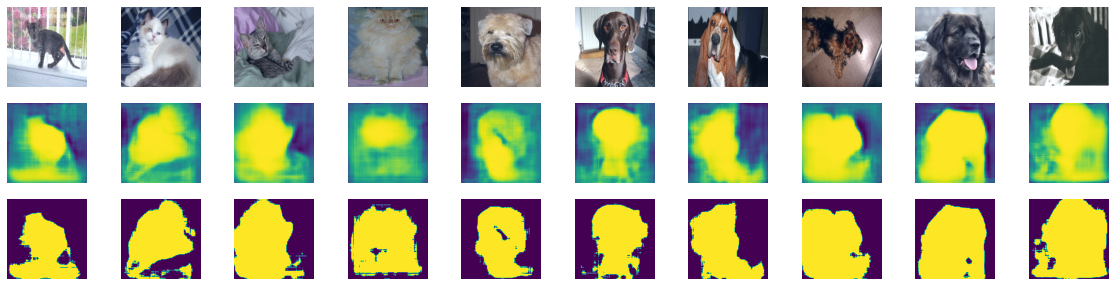

In [6]:
p = np.random.permutation(len(val_x))[:10] # display 10 images

pred_y = model.predict(val_x[p]) # probability map
imgs = val_x[p]

THRESHOLD = np.mean(pred_y[:,:,:,0])
mask = np.where(pred_y[:,:,:,0] > THRESHOLD, 1, 0) # convert probability map to mask

plt.figure(figsize=(20,5))
for i in range(len(imgs)):
    plt.subplot(3, len(imgs),i+1)
    plt.imshow((imgs[i]+1.9)/3.8)
    plt.axis('off')
    plt.subplot(3, len(imgs),len(imgs)+i+1)
    plt.imshow(pred_y[i,:,:,0])
    plt.axis('off')
    plt.subplot(3, len(imgs),2*len(imgs)+i+1)
    plt.imshow(mask[i])
    plt.axis('off')


### SVM and GrabCut foreground/background refinement Demo

In [52]:
def vector_generator(img, lmap, window_size=10, stride=5):
    """
    Use a sliding window to get the mean RGB value vectors 
    with likehood for foreground and background
    """
    vectors = [] # store the mean RGB vectors
    likehoods = [] # store the mean like hood values
    H, W = img.shape[0], img.shape[1]
    i = 0
    while i + window_size <= H:
        j = 0
        while j + window_size <= W:
            img_patch = img[i:i+window_size, j:j+window_size, :]
            map_patch = lmap[i:i+window_size, j:j+window_size, 0]
            rgb = [np.mean(img_patch[:,:,0]),
                   np.mean(img_patch[:,:,1]),
                   np.mean(img_patch[:,:,2])]
            vectors.append(rgb)
            likehoods.append(np.mean(map_patch))
            j += stride
        i += stride
    return np.array(vectors), np.array(likehoods)
            

In [9]:
val_x = None
del val_x

# Load training images
list_ids = []
for fname in os.listdir('./data/224x224/train'):
    if fname.startswith('_') == False and fname.endswith('.jpg'):
        list_ids.append(fname[:-4])        
train_x, train_y = pet.load_data(data_path='./data/224x224/train', list_ids=list_ids, width=224, height=224, standardization=False)
train_y = None; del train_y # remove val_y to save memory

"""use model trained on pseudo labels to generate likehood maps"""
likehood_maps = model.predict(train_x) # likehood map

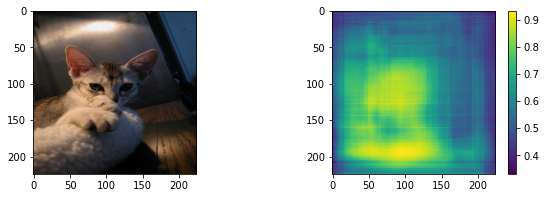

In [112]:
idx = 0

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(train_x[idx])
plt.subplot(1,2,2)
plt.imshow(likehood_maps[idx,:,:,0])
plt.colorbar()

In [113]:
X, Y = vector_generator(train_x[idx],likehood_maps[idx], window_size=10, stride=5)
print(X.shape)

(1849, 3)


In [114]:
from sklearn.svm import SVR

svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X, Y)


C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [115]:
X_pixels, _ = vector_generator(train_x[idx],likehood_maps[idx], window_size=1, stride=1)
Y_score = svr.predict(X_pixels)


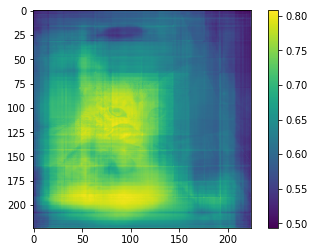

In [116]:
Y_score = np.reshape(Y_score, (224,224))
seed = (Y_score + likehood_maps[idx,:,:,0])/2
plt.imshow(seed)
plt.colorbar()

In [117]:
threshold_01 = (seed.mean() - seed.min())/2 + seed.min() # threshold to separate probabily BG and difinitely BG
threshold_12 = seed.mean() # threshold to separate probabily BG and probabily FG
threshold_23 = (seed.max() - seed.mean())/2 + seed.mean() # threshold to separate probabily FG and difinitely FG
print(threshold_01)
print(threshold_12)
print(threshold_23)

0.5758719878829845
0.6582773756649879
0.7331071467070933


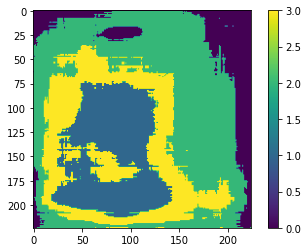

In [118]:
# 0: BG, 1: FG, 2: probabily BG, 3: probabily FG
mask = np.zeros(seed.shape, dtype=np.uint8)
indices = seed < threshold_01
mask[indices] = cv2.GC_BGD # BG
indices = (seed > threshold_01) * (seed < threshold_12)
mask[indices] = cv2.cv2.GC_PR_BGD # PR_BG
indices = (seed > threshold_12) * (seed < threshold_23)
mask[indices] = cv2.GC_PR_FGD # PR_FG
indices = seed > threshold_23
mask[indices] = cv2.GC_FGD # FG

plt.imshow(mask)
plt.colorbar()

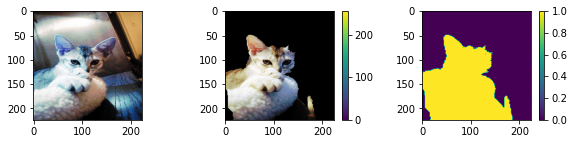

In [119]:
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

img_ = cv2.imread('./data/224x224/train/'+list_ids[idx]+'.jpg')
for c in range(3):
    img_[...,c] = cv2.equalizeHist(img_[...,c]) # apply histogram equalization
img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_MASK)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')

img = img*mask[:,:,np.newaxis]

plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(img_)
plt.subplot(1,3,2)
plt.imshow(img)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(mask)
plt.colorbar()

In [29]:
"""TODO: Intra and Inter cluster learning refinement"""
# Create a new notebook


'TODO: Intra and Inter cluster learning'

In [ ]:
"""TODO: Semi-supervised learning to improve result"""
# Create a new notebook